# Notebook Capítulo Empírico

Abaixo um roteiro em células de notebook que cobre:

1. Importação de pacotes
2. Carregar os dados JSON
3. Unir datasets (merge por data)
4. Criar retorno mensal do IBOV (%)
5. Estatísticas descritivas
6. Gráficos comparativos
7. Regressão Linear Simples (modelo principal)
8. Gráfico de dispersão com linha de regressão
9. Análise complementar: SELIC Meta (% a.a.)


## 1. Importação de pacotes

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

Matplotlib is building the font cache; this may take a moment.


## 2. Carregar os dados JSON

In [ ]:
# base arquivos
base_path = Path("../dados")

ibov = pd.read_json(base_path / "history_ibov.json")
selic = pd.read_json(base_path / "history_selic.json")          # acumulada % a.m.
selic_meta = pd.read_json(base_path / "history_selic_meta.json") # meta % a.a.

# Converter datas
for df in [ibov, selic, selic_meta]:
    df["date_reference"] = pd.to_datetime(df["date_reference"])

# Renomear colunas de valor
ibov = ibov.rename(columns={"value": "ibov"})
selic = selic.rename(columns={"value": "selic_mensal"})
selic_meta = selic_meta.rename(columns={"value": "selic_meta"})


## 3. Unir datasets (merge por data)

In [ ]:
df = (
    ibov[["date_reference","ibov"]]
    .merge(selic[["date_reference","selic_mensal"]], on="date_reference")
    .merge(selic_meta[["date_reference","selic_meta"]], on="date_reference")
)

df.head()


,date_reference,ibov,selic_mensal,selic_meta
0,2010-01-01,65401.77,0.66,8.62
1,2010-02-01,66503.27,0.59,8.62
2,2010-03-01,70371.54,0.76,8.61
3,2010-04-01,67529.73,0.67,8.70
4,2010-05-01,63046.51,0.75,9.38


## 4. Criar retorno mensal do IBOV (%)

In [14]:
df["ibov_return"] = df["ibov"].pct_change() * 100
df = df.dropna().reset_index(drop=True)

df.head()


,date_reference,ibov,selic_mensal,selic_meta,ibov_return
0,2010-03-01,70371.54,0.76,8.61,5.816661
1,2010-04-01,67529.73,0.67,8.70,-4.038294
2,2010-05-01,63046.51,0.75,9.38,-6.638883
3,2010-06-01,60935.90,0.79,9.91,-3.347703
4,2010-07-01,67515.40,0.86,10.30,10.797412


## 5. Estatísticas descritivas

In [9]:
print(df[["ibov_return","selic_mensal","selic_meta"]].describe())

# Correlação
print("\nCorrelação:")
print(df[["ibov_return","selic_mensal","selic_meta"]].corr())


       ibov_return  selic_mensal  selic_meta
count   179.000000    179.000000  179.000000
mean      0.531733      0.754358    9.484358
std       6.122085      0.273494    3.476202
min     -29.904330      0.130000    1.900000
25%      -3.353382      0.540000    6.800000
50%       0.519234      0.810000   10.400000
75%       4.497544      0.955000   12.150000
max      16.968345      1.220000   14.140000

Correlação:
              ibov_return  selic_mensal  selic_meta
ibov_return      1.000000     -0.028064   -0.023556
selic_mensal    -0.028064      1.000000    0.982295
selic_meta      -0.023556      0.982295    1.000000


## 6. Gráficos comparativos

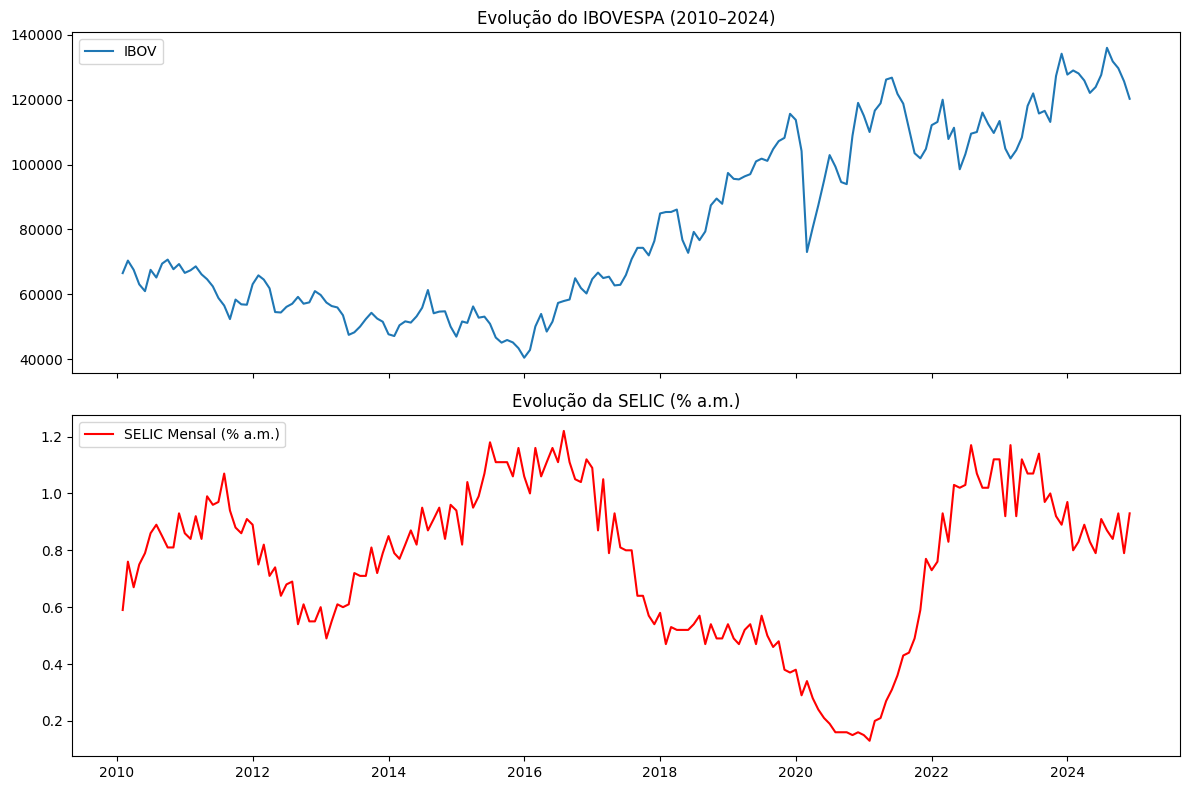

In [10]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

# Série IBOV vs SELIC
ax[0].plot(df["date_reference"], df["ibov"], label="IBOV")
ax[0].set_title("Evolução do IBOVESPA (2010–2024)")
ax[0].legend()

ax[1].plot(df["date_reference"], df["selic_mensal"], label="SELIC Mensal (% a.m.)", color="red")
ax[1].set_title("Evolução da SELIC (% a.m.)")
ax[1].legend()

plt.tight_layout()
plt.show()


## 7. Regressão Linear Simples (modelo principal)

In [11]:
X = sm.add_constant(df["selic_mensal"])  # regressora
y = df["ibov_return"]                    # dependente

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            ibov_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1395
Date:                Mon, 08 Sep 2025   Prob (F-statistic):              0.709
Time:                        21:46:31   Log-Likelihood:                -577.75
No. Observations:                 179   AIC:                             1159.
Df Residuals:                     177   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0056      1.349      0.745   

## 8. Gráfico de dispersão com linha de regressão

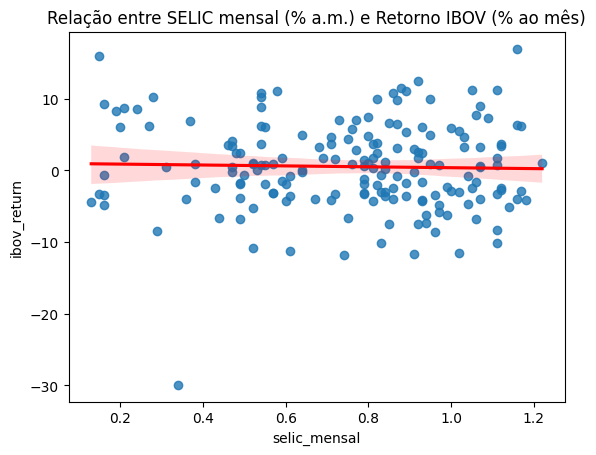

In [12]:
sns.regplot(x="selic_mensal", y="ibov_return", data=df, ci=95, line_kws={"color":"red"})
plt.title("Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)")
plt.show()

# 9. Análise complementar: SELIC Meta (% a.a.)

In [13]:
X_meta = sm.add_constant(df["selic_meta"])
ols_meta = sm.OLS(df["ibov_return"], X_meta).fit()
print(ols_meta.summary())

                            OLS Regression Results                            
Dep. Variable:            ibov_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.09827
Date:                Mon, 08 Sep 2025   Prob (F-statistic):              0.754
Time:                        21:47:45   Log-Likelihood:                -577.77
No. Observations:                 179   AIC:                             1160.
Df Residuals:                     177   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9252      1.336      0.692      0.4